In [1]:
from modules import conv_block, separable_conv_block,conv_transpose, out_sep_conv_block
from u_encoder_64 import U_Encoder
from U_decoder_64 import U_Decoder
from weights import gaussian_neighbor, intensity, RAG, normalized_cuts, reconstruction_loss
#from n_cuts import 


import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

import time

import cv2
import PIL
from PIL import ImageEnhance, Image
import matplotlib.pyplot as plt
from scipy import ndimage, misc

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
seed = 42
np.random.seed = seed

BATCH_SIZE = 3
EPOCHS = 25
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_CHANNELS = 3
#classes = 5
MSE = tf.keras.losses.MeanSquaredError()
X_train = np.load('X_train.npy') 
images = X_train[[210,330, 434]]


#X_test = np.load('X_test.npy') # .npy extension is added if not given

#image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
# .npy extension is added if not given
#Y_train = np.load('Y_train.npy')

#X_train =X_train.astype('float32') / 255
#X_test = X_test.astype('float32') / 255



In [59]:
MSE

In [3]:
images = np.array([image_0, image_1, image_2])


NameError: name 'image_0' is not defined

In [4]:
factor = 1.3
for i in range(3):
  im_pil = Image.fromarray(images[i])
  enhancer = ImageEnhance.Contrast(im_pil)
  im_pik = enhancer.enhance(factor)
  images[i] = np.array(im_pik)


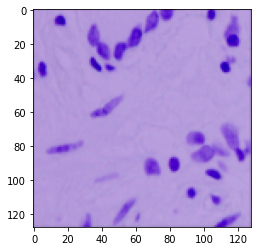

In [5]:
plt.imshow(images[2])

In [6]:

images=images.astype('float32') /255


In [7]:

img0 = cv2.resize(images[0], dsize = (96,64))
img1 = cv2.resize(images[1], dsize = (96,64))
img2 = cv2.resize(images[2], dsize = (96,64))

imgs = np.array([img0, img1, img2])

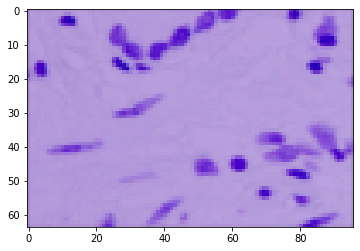

In [53]:
plt.imshow(imgs[2])

In [54]:
image.shape

NameError: name 'image' is not defined

In [8]:
#stime = time.time()
classes = 3


encoder = U_Encoder(classes, activation = 'softmax')
decoder = U_Decoder(num_channels = 3, activation = 'linear')


encoder.build((None,64 ,96,3))
decoder.build((None,64 ,96,classes))

encoder.summary()
decoder.summary()



2022-02-04 15:58:49.512085: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-04 15:58:49.512303: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "u__encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_block (conv_block)      multiple                  2832      
_________________________________________________________________
separable_conv_block (separa multiple                  2160      
_________________________________________________________________
out_sep_conv_block (out_sep_ multiple                  7392      
_________________________________________________________________
conv_transpose (conv_transpo multiple                  12352     
_________________________________________________________________
conv_transpose_1 (conv_trans multiple                  3360      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  51        
Total params: 28,147
Trainable params: 27,827
Non-trainable params: 320
____________________

In [9]:
#@tf.function
def train_step(X_batch,graph_spatial):
    #print("Batch ", X_batch.shape)
    loss_ns = []
    loss_rc = []
    with tf.GradientTape(persistent = True) as tape:
        out_enc = encoder(X_batch)
        out_dec = decoder(out_enc)
        out_enc = tf.reshape(out_enc, (out_enc.shape[0],-1,out_enc.shape[3]))
        print("Encoder Output shape ", out_enc.shape)
        data_ncuts = (X_batch, out_enc)
       # print("Calculating Loss")
        start2 = time.time()
      
        ncuts_loss =tf.map_fn(lambda x: normalized_cuts(x[0], x[1], classes, graph_spatial , sigma_I=10), data_ncuts, fn_output_signature= tf.float32, parallel_iterations = 32)
        ncuts_loss = tf.math.reduce_mean(ncuts_loss)
        loss_ns.append(ncuts_loss)
        #ncuts_loss = batch_normalized_cuts(X_batch, out_enc, 2, graph_spatial , sigma_I=10)
        print(" Ncuts loss is ", ncuts_loss)
    
        recon_loss = reconstruction_loss(MSE, out_dec, X_batch)
        loss_rc.append(recon_loss)
        print(" Reconstruction loss is  ", recon_loss)
    
    
       
        
        
    
    print("calculating Gradient")
    grads_ncuts = tape.gradient(ncuts_loss, encoder.trainable_variables)

    grads_recon = tape.gradient(recon_loss, encoder.trainable_variables)
    #print(tf.trainable_variables())
    grads = grads_ncuts+grads_recon
    #optimizer.apply_gradients(zip(grads_ncuts, encoder.trainable_variables))
    
    optimizer.apply_gradients(zip(grads, encoder.trainable_variables))
    
    grads_recon = tape.gradient(recon_loss, decoder.trainable_variables)
    optimizer.apply_gradients(zip(grads_recon, decoder.trainable_variables))
    
    print("Time Taken to calculate loss for whole batch is ", time.time()-start2, " seconds")
    return loss_ns, loss_rc


In [ ]:
imgs.shape

(3, 54, 96, 3)

In [ ]:
type(image)

numpy.ndarray

In [18]:
#num_updates = int(X_train.shape[0]/BATCH_SIZE )
#num_updates = 30 
EPOCHS = 150
classes = 3
lr = 0.003
loss_cuts = []
loss_recon = []

#graph_spatial = gaussian_neighbor(X_train.shape[1], X_train.shape[2],radius=5, sigma_x=4) #CELL
graph_spatial = gaussian_neighbor(imgs.shape[1], imgs.shape[2],radius=5, sigma_x=4) #derma
for epoch in range(1, EPOCHS+1):
   
    if epoch % 50 == 0 :
       
       lr = lr*0.75
       print("LEARNING RATE IS CHANGED ", lr)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    #optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    print("[INFO] starting Epoch {}/{}...".format(epoch , EPOCHS), end="")
    epochStart = time.time()
    for i in range(0, 1):
    # determine starting and ending slice indexes for the current
    # batch
        print("Update number ", i)
        #start = i * BATCH_SIZE 
        #end = start + BATCH_SIZE 
    # take a step
        #weights = RAG(X_train[start:end])
        #train_loss = train_step(X_train[start:end], graph_spatial)
        #ls_ns, ls_rc= train_step(X_train, graph_spatial) #Cell Images
        ls_ns, ls_rc= train_step(imgs, graph_spatial) # derma image
        loss_cuts.append(ls_ns)
        loss_recon.append(ls_rc)
        
    if epoch %10 == 0:
      encoder.save_weights('encoder_3_10_'+str(epoch)+'.h5')
      decoder.save_weights('decoder_3_10_'+str(epoch)+'.h5')


    epochEnd = time.time()
    elapsed = (epochEnd - epochStart) / 60.0
    print("Epoch {}/{} took {:.4} minutes".format(epoch + 1, EPOCHS, elapsed))
#model.compile(optimizer=optimizer, loss=custom_loss, metrics=["acc"])

#callbacks  = [keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'), 
              #keras.callbacks.TensorBoard(log_dir= '/Users/mariam/Desktop/Leiden_Courses/Research/Code/Unet/Unet_Wnet/logs')]

graph shape  (6144, 6144)
Runtime of obtaining gaussian Neighbor is  0.6053459644317627  seconds
[INFO] starting Epoch 1/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.66169167, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.017114004, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  8.055054903030396  seconds
Epoch 2/150 took 0.1371 minutes
[INFO] starting Epoch 2/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(1.1671184, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.020104947, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  11.020604848861694  seconds
Epoch 3/150 took 0.1851 minutes
[INFO] starting Epoch 3/150...Update number  0
Encoder Output sha

Time Taken to calculate loss for whole batch is  10.71609091758728  seconds
Epoch 21/150 took 0.182 minutes
[INFO] starting Epoch 21/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.40379548, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.018054424, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  9.274526834487915  seconds
Epoch 22/150 took 0.1555 minutes
[INFO] starting Epoch 22/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.28767657, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.018245306, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  10.633919954299927  seconds
Epoch 23/150 took 0.1782 minutes
[INFO] starting Epoch 23/150...Update number  0
E

Time Taken to calculate loss for whole batch is  5.959764003753662  seconds
Epoch 41/150 took 0.1039 minutes
[INFO] starting Epoch 41/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.31465182, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.014390198, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  6.195653200149536  seconds
Epoch 42/150 took 0.1049 minutes
[INFO] starting Epoch 42/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.37092662, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.023515377, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  7.087852716445923  seconds
Epoch 43/150 took 0.1191 minutes
[INFO] starting Epoch 43/150...Update number  0
E

 Ncuts loss is  tf.Tensor(0.3226543, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.018593034, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  6.523367166519165  seconds
Epoch 61/150 took 0.1118 minutes
[INFO] starting Epoch 61/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.28313592, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.011213384, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  6.092097043991089  seconds
Epoch 62/150 took 0.1024 minutes
[INFO] starting Epoch 62/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.24665324, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is  

Time Taken to calculate loss for whole batch is  7.144490003585815  seconds
Epoch 80/150 took 0.1201 minutes
[INFO] starting Epoch 80/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.8949394, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.012004674, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  7.74761700630188  seconds
Epoch 81/150 took 0.1326 minutes
[INFO] starting Epoch 81/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.8821416, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.015290764, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  6.035977840423584  seconds
Epoch 82/150 took 0.1014 minutes
[INFO] starting Epoch 82/150...Update number  0
Enco

Time Taken to calculate loss for whole batch is  7.650275230407715  seconds
Epoch 100/150 took 0.1286 minutes
LEARNING RATE IS CHANGED  0.0016875000000000002
[INFO] starting Epoch 100/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.22001761, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.0140821785, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  7.244203805923462  seconds
Epoch 101/150 took 0.1228 minutes
[INFO] starting Epoch 101/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.4971808, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.010945118, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  6.4581098556518555  seconds
Epoch 102/150 took 0.1084 min

 Ncuts loss is  tf.Tensor(0.22426128, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.01225443, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  7.974861145019531  seconds
Epoch 120/150 took 0.1338 minutes
[INFO] starting Epoch 120/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.38879606, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.010437086, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  7.213802814483643  seconds
Epoch 121/150 took 0.1238 minutes
[INFO] starting Epoch 121/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.2241128, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss i

Time Taken to calculate loss for whole batch is  6.853564739227295  seconds
Epoch 139/150 took 0.1156 minutes
[INFO] starting Epoch 139/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.21782935, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.012192687, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  5.902278184890747  seconds
Epoch 140/150 took 0.09966 minutes
[INFO] starting Epoch 140/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.39180416, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.011502448, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  5.678606986999512  seconds
Epoch 141/150 took 0.09798 minutes
[INFO] starting Epoch 141/150...Update num

In [ ]:
np.save("loss_ncuts.npy", loss_cuts)
np.save("loss_recon.npy", loss_recon)


In [19]:
pip install Box2D

  Using cached Box2D-2.3.2.tar.gz (427 kB)
  ERROR: Command errored out with exit status 1:
   command: /Users/mariam/miniforge3/envs/env0_tensorflow/bin/python -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/4w/dngsl7f10yd84zm5z197jl340000gn/T/pip-install-r3q95lce/box2d_3438090e3646463a954bced0b6abee3c/setup.py'"'"'; __file__='"'"'/private/var/folders/4w/dngsl7f10yd84zm5z197jl340000gn/T/pip-install-r3q95lce/box2d_3438090e3646463a954bced0b6abee3c/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/4w/dngsl7f10yd84zm5z197jl340000gn/T/pip-wheel-bbgxeiqa
       cwd: /private/var/folders/4w/dngsl7f10yd84zm5z197jl340000gn/T/pip-install-r3q95lce/box2d_3438090e3646463a954bced0b6abee3c/
  Complete out

Failed to build Box2D
    Running setup.py install for Box2D ... done
  DEPRECATION: Box2D was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install swig -y


Usage:   
  /Users/mariam/miniforge3/envs/env0_tensorflow/bin/python -m pip install [options] <requirement specifier> [package-index-options] ...
  /Users/mariam/miniforge3/envs/env0_tensorflow/bin/python -m pip install [options] -r <requirements file> [package-index-options] ...
  /Users/mariam/miniforge3/envs/env0_tensorflow/bin/python -m pip install [options] [-e] <vcs project url> ...
  /Users/mariam/miniforge3/envs/env0_tensorflow/bin/python -m pip install [options] [-e] <local project path> ...
  /Users/mariam/miniforge3/envs/env0_tensorflow/bin/python -m pip install [options] <archive url/path> ...

no such option: -y
Note: you may need to restart the kernel to use updated packages.
